Copy of 11 with MAE

In [1]:
AEversion = '14'

In [2]:
import numpy as np
import os, sys, pickle
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

imperium-sm.hep.caltech.edu  Wed Jul 17 05:12:03 2019
[0] GeForce GTX 1080 | 36'C,   0 % |    11 /  8119 MB |
[1] GeForce GTX 1080 | 25'C,   0 % |  3040 /  8119 MB | ocerri(3029M)
[2] GeForce GTX 1080 | 25'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 68'C,  96 % |  1782 /  8119 MB | 3041(1771M)
[4] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 39'C,  20 % |  1681 /  8119 MB | ocerri(1147M) ocerri(523M)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sys.path.append('../lib')
from progressBar import ProgressBar
from utils import EarlyStopping, createROC_curve, ELU_ProbNorm

In [6]:
dnd = []

## Get the dataset

In [7]:
from dataLoaders import ParticleDataset

In [8]:
dataset = ParticleDataset(template='../data/20190717_50part_PtOrder_v3/{}.npy', N_part=50, N_features=11)

In [9]:
dataset.loadTrainSM(N_train_max=1e6)
dataset.charge(dataset.SMMix_train)

Fetching Wlnu
Fetching qcd
Fetching Zll
Fetching ttbar
Expected 1.00M train
Expected 1.00M val

Loading Wlnu
Loading qcd
Loading Zll
Loading ttbar
+--------+----------+-------+------+
| Sample | Evts tot | Train | Val  |
+--------+----------+-------+------+
|  Wlnu  |  5618k   |  592k | 592k |
|  qcd   |  1166k   |  338k | 338k |
|  Zll   |  1777k   |  67k  | 67k  |
| ttbar  |  6542k   |   3k  |  3k  |
+--------+----------+-------+------+
Tot training 1.00 M
Tot val 1.00 M


In [10]:
dataset.loadValidationSamples('BSM', N_max=1000000000000000)

Loading Ato4l (47.7k)
Loading leptoquark (273.6k)
Loading hToTauTau (685.8k)
Loading hChToTauNu (339.0k)


## Define the model

In [11]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=(self.p)*self.No,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,1], min_val=-5, max_val=5).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,2]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        
        # charge & pId category
        cpId_cat = ELU_ProbNorm(x_raw[:,:,3:])
        
        x = torch.cat((pt, eta, phi, cpId_cat), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            os.environ['CUDA_VISIBLE_DEVICES'] = str(N_GPU)
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [38]:
Latent_dimension = 60
Hidden_dimension = 100

model = AEDenseNet(
                   N_part=dataset.inputs.shape[1],
                   N_features=dataset.inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=550, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=60, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (PhiD): Sequential(
      (0): Linear(in_features=60, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=550, bias=True)
    )
  )
)

Trainable parameters: 143010


In [39]:
model.useGPU(0)

Current device: 0 (8 available)
imperium-sm.hep.caltech.edu  Wed Jul 17 05:44:04 2019
[0] GeForce GTX 1080 | 31'C,  33 % |   532 /  8119 MB | ocerri(521M)
[1] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[2] GeForce GTX 1080 | 25'C,   0 % |    10 /  8119 MB |
[3] GeForce GTX 1080 | 69'C,  96 % |  1782 /  8119 MB | 3041(1771M)
[4] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |
[5] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |    11 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |    11 /  8119 MB |


## Loss

In [40]:
def criterion(x_in, x_out, reduction='mean'):
    # Gaussian
    NLL_gauss = torch.abs(x_in[:,:,:3] - x_out[:,:,:3])
    
    #Cat cross entropy charge-pId
    log_p = torch.log(x_out[:,:,3:]).view(-1, 8)
    true_cat = torch.argmax(x_in[:,:,3:], dim=2)
    NLL_cat = F.nll_loss(log_p, true_cat.view(-1).long(), reduction='none').view(-1, x_in.shape[1], 1)
    
    NLL_tot = torch.cat((0.1*NLL_gauss, 10*NLL_cat), 2)
    NLL_perEvent = torch.mean(NLL_tot, dim=1)
    
    if reduction == 'mean':
        NLL_mean = torch.mean(NLL_perEvent, dim=0)
        return torch.sum(NLL_mean), NLL_mean.cpu().detach().numpy()
    elif reduction == 'none':
        return torch.sum(NLL_perEvent, dim=1)
    else:
        raise

## Training

In [41]:
training_params = {'batch_size': 1000,
                   'shuffle': True,
                   'num_workers': 3
                  }

max_epochs = 1000

eval_params = {'batch_size': 50000,
               'num_workers': 3
              }

In [42]:
torch.autograd.set_detect_anomaly(True);

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=5)

In [44]:
train_loss = []
BSM_eff = {'ep': []}
for n in dataset.BSM_names:
    BSM_eff[n] = []

loss_history = {'train': [], 'val': [], 'val_feat': []}
optimizer.zero_grad()
try:
    for epoch in range(max_epochs):
        batch_loss = []

        #### ---- Training ---- ####
        model.train()
        dataset.charge(dataset.SMMix_train)
        train_data_iter = torch.utils.data.DataLoader(dataset, **training_params)
        pb = ProgressBar(len(train_data_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch))
        for local_x, _ in train_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)

            x_prime = model(local_x)        
            loss, _ = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid training loss!!!')
                raise NameError('LossNAN')
            batch_loss.append(loss.item())

            tail_label = 'Loss: {:2.2e}'.format(loss.item())
            if len(loss_history['train']) > 0:
                tail_label += ' ({:2.2e})'.format(loss.item() - loss_history['train'][-1][-1])
            pb.show(len(batch_loss)-1, tail_label=tail_label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
#         aux_loss = 0
#         N_batches = 0
#         for local_x, _ in train_data_iter:
#             if model.onGPU:
#                 local_x = local_x.cuda(model.N_GPU)
#             x_prime = model(local_x)
#             loss, _ = criterion(local_x, x_prime)
#             aux_loss += loss.item()
#             N_batches += 1
#         batch_loss.append(aux_loss/N_batches)

        printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
        if len(loss_history['train']) > 0:
            printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - loss_history['train'][-1][-1])
        if len(loss_history['train']) > 1:
            d2L_de2 = batch_loss[-1] - 2*loss_history['train'][-1][-1] + loss_history['train'][-2][-1]
            printout +=' - Trend: {:2.2e}'.format(d2L_de2)
        print(printout)

        loss_history['train'].append(batch_loss)

        #### ---- Validation ---- ####
        dataset.charge(dataset.SMMix_val)
        val_data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
        aux_loss = 0
        aux_feat = np.zeros((4))
        N_batches = 0
        for local_x, _ in val_data_iter:
            if model.onGPU:
                local_x = local_x.cuda(model.N_GPU)
            x_prime = model(local_x)
            loss, NLL_feat = criterion(local_x, x_prime)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print('Invalid validation loss!!!')
                raise NameError('LossNAN')
            aux_loss += loss.item()
            aux_feat += NLL_feat
            N_batches += 1
        loss_history['val'].append(aux_loss/N_batches)
        loss_history['val_feat'].append(aux_feat/N_batches)
        printout = 'Val Loss: {:2.2e}'.format(loss_history['val'][-1])
        printout += ' Pt:{:.2f} - Eta:{:.2f} - Phi:{:.2f} - Cat:{:.2f}'.format(*loss_history['val_feat'][-1])
        print(printout)
        if epoch > 0:
            if loss_history['val'][-1] < np.min(loss_history['val']):
                print('[INFO]: Saving best model')
                torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_best.pkl')

        print('')
        if not earlyStopping.check(loss_history['val'][-1]):
            break

        scheduler.step(batch_loss[-1])
        
        #### ---- Periodic save model ---- ####
        if epoch%50 == 0:
            torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'_epoch{}.pkl'.format(epoch))

        #### ---- Anomaly Detection monitor ---- ####
        if False and epoch%10 == 0:
            print('------------ Anomaly Detection monitor ------------')
            BSM_eff['ep'].append(epoch)
            dataset.loss['SMMix'] = np.zeros((0))

            pb = ProgressBar(len(val_data_iter), percentPrecision=5, headLabel='SM Mix: ')
            for i, (local_x, _) in enumerate(val_data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss['SMMix'] = np.concatenate((dataset.loss['SMMix'], loss))

            p_SM = np.logspace(base=10, start=-5, stop=-3, num=3)
            if not 'p_SM' in BSM_eff.keys():
                BSM_eff['p_SM'] = p_SM
            q_SM = np.quantile(dataset.loss['SMMix'], 1-p_SM)

            table = PrettyTable(['SM Mix'] + list(map(lambda x: '{:1.2e}'.format(x), p_SM)))

            for n in dataset.BSM_names:
                dataset.loss[n] = np.zeros((0))

                dataset.charge(dataset.valSamples[n])
                data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
                pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
                for i, (local_x, _) in enumerate(data_iter):
                    pb.show(i)
                    if model.onGPU:
                        local_x = local_x.cuda(model.N_GPU)

                    x_prime = model(local_x)
                    loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
                    dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

                out = dataset.loss[n] > np.atleast_2d(q_SM).T
                p_BSM = np.float64(np.sum(out, axis=1, dtype=np.float128)/dataset.loss[n].shape[0])
                BSM_eff[n].append(p_BSM)

                table.add_row([n] + list(map(lambda x: '{:1.2e}'.format(x), p_BSM)))
            print(table)                
            print('---------------------------------------------------\n\n')

    model.eval()
    torch.save(model.state_dict(), 'data/model_state_dict_dAE_v'+AEversion+'.pkl');
except NameError:
    if epoch > 0:
        print ('\n\nModel ended up nan. Recovering best model\n')
        model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_best.pkl'))
    else:
        raise

Epoch 0: [####################]  100% - Tot. time: 38.5 s           
Loss: 6.11e+00
Val Loss: 6.10e+00 Pt:0.01 - Eta:0.22 - Phi:0.15 - Cat:5.72

Epoch 1: [####################]  100% - Tot. time: 39.3 s                       
Loss: 4.50e+00 - Delta: -1.61e+00
Val Loss: 4.53e+00 Pt:0.01 - Eta:0.22 - Phi:0.15 - Cat:4.15

Epoch 2: [####################]  100% - Tot. time: 38.9 s                       
Loss: 4.34e+00 - Delta: -1.62e-01 - Trend: 1.45e+00
Val Loss: 4.36e+00 Pt:0.01 - Eta:0.22 - Phi:0.15 - Cat:3.98

Epoch 3: [####################]  100% - Tot. time: 38.7 s                      
Loss: 5.92e+00 - Delta: 1.58e+00 - Trend: 1.74e+00
Val Loss: 5.96e+00 Pt:0.01 - Eta:0.22 - Phi:0.15 - Cat:5.58

Epoch 4: [####################]  100% - Tot. time: 38.7 s                       
Loss: 6.98e+00 - Delta: 1.06e+00 - Trend: -5.24e-01
Val Loss: 6.97e+00 Pt:0.01 - Eta:0.22 - Phi:0.15 - Cat:6.59

Epoch 5: [####################]  100% - Tot. time: 38.4 s                       
Loss: 7.09e+00 - D

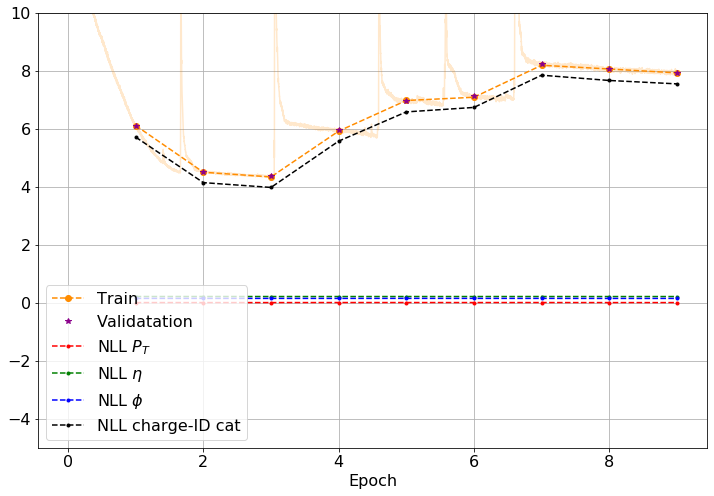

In [45]:
loss_history['train'] = np.array(loss_history['train'])
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(12,8))

train_loss_flat = loss_history['train'].flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(loss_history['train'].shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, loss_history['train'].shape[0]+1)
plt.plot(x, loss_history['train'][:,-1], 'o--', label='Train', color='darkorange')
plt.plot(x, loss_history['val'], '*', label='Validatation', color='darkmagenta')

lval_feat = np.array(loss_history['val_feat'])
plt.plot(x, lval_feat[:,0], '--.', label='NLL $P_T$', color='r')
plt.plot(x, lval_feat[:,1], '--.', label='NLL $\eta$', color='g')
plt.plot(x, lval_feat[:,2], '--.', label='NLL $\phi$', color='b')
plt.plot(x, lval_feat[:,3], '--.', label='NLL charge-ID cat', color='k')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
# plt.yscale('log')
plt.ylim(-5, 10)

f.savefig('plots/TrainingHistory_dAE_v'+AEversion+'.png')

f = open('data/TrainingHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(loss_history, f)
f.close()

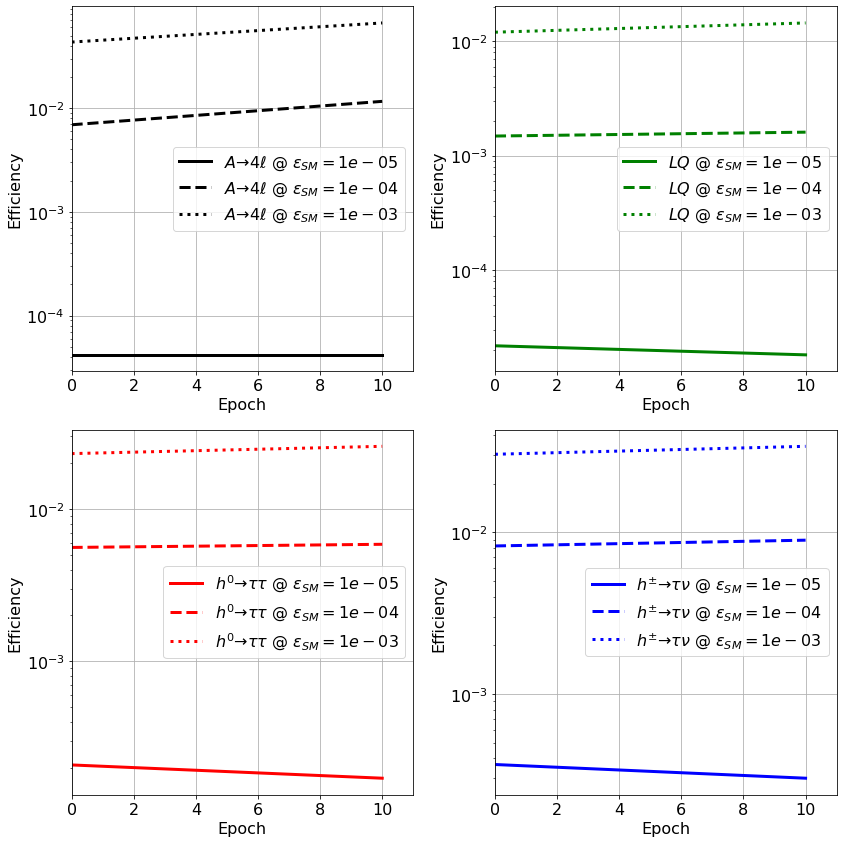

In [20]:
f, ax_arr = plt.subplots(2,2, figsize=(12,12))
styles = ['-', '--', ':']
x = BSM_eff['ep']
for i, n in enumerate(dataset.BSM_names):  
    ax = ax_arr[int(i/2),i%2]
    
    BSM_eff[n] = np.array(BSM_eff[n])
    
    for j in range(BSM_eff['p_SM'].shape[0]):
#         ax.plot(x, len(x)*[BSM_eff['p_SM'][j]], color='gray', lw=2, linestyle=styles[j])
        ax.plot(x, BSM_eff[n][:,j], 
                color=dataset.process_colors[n], lw=3, linestyle=styles[j], 
                label=dataset.process_labels[n] + ' @ $\epsilon_{{SM}} = {:1.0e}$'.format(BSM_eff['p_SM'][j]))
        
    ax.set_xlim([0, x[-1]+1])
#     ax.set_ylim([1e-6, 5])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.grid()
    
    ax.legend(loc='best')
    
f.tight_layout()

f = open('data/AnomalyDetectionHistory_dAE_v'+AEversion+'.pkl', 'wb')
pickle.dump(BSM_eff, f)
f.close()

In [21]:
# model.load_state_dict(torch.load('data/model_state_dict_dAE_v'+AEversion+'_epoch400.pkl'))

# Convergence check

In [22]:
dataset.charge(dataset.SMMix_val)
x = dataset.inputs
model.eval()
if model.onGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda(model.N_GPU)).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

/nfshome/ocerri/miniconda2/envs/PartAN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


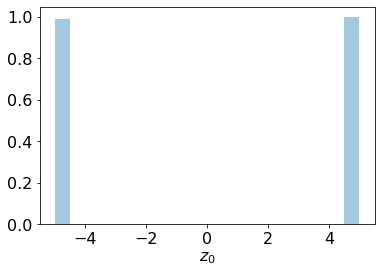

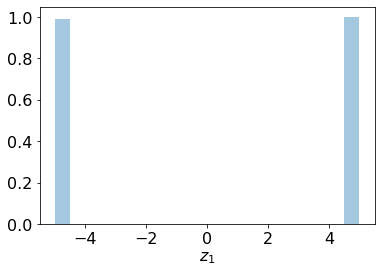

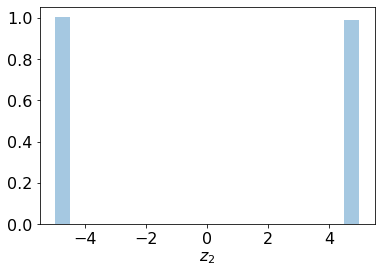

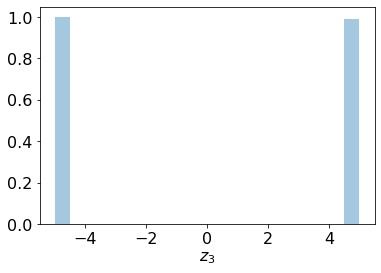

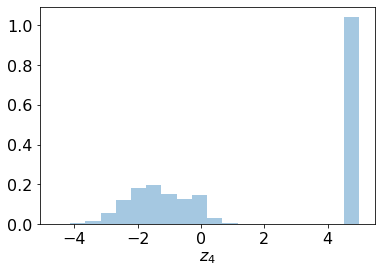

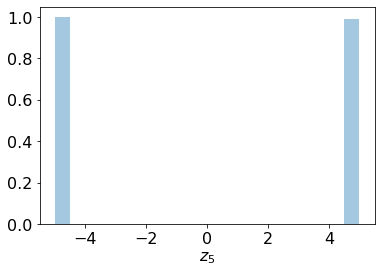

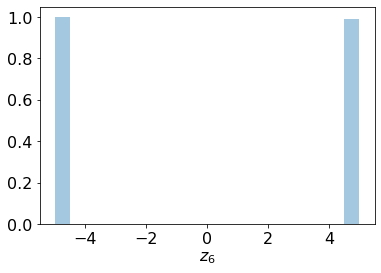

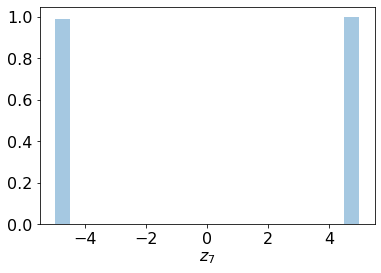

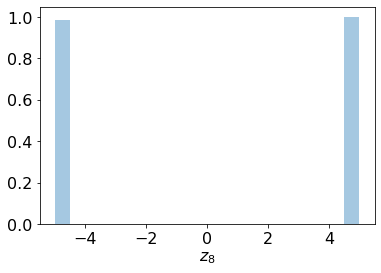

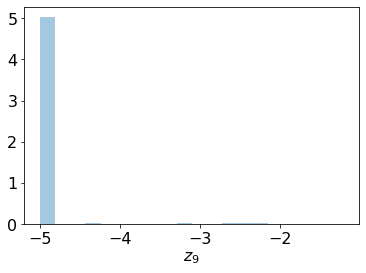

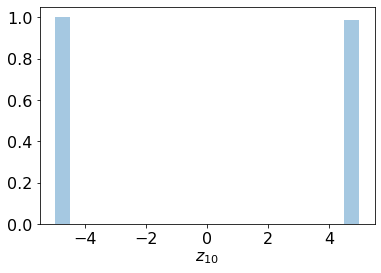

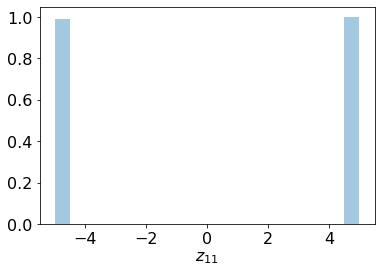

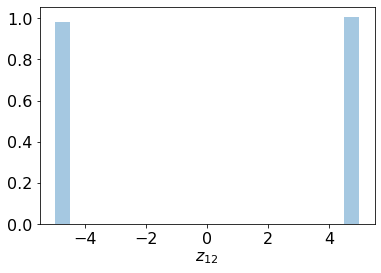

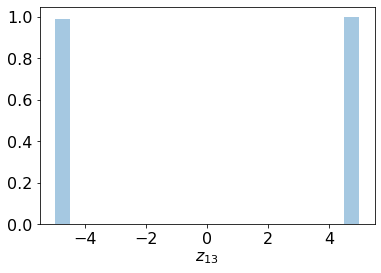

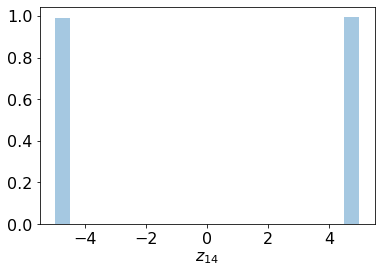

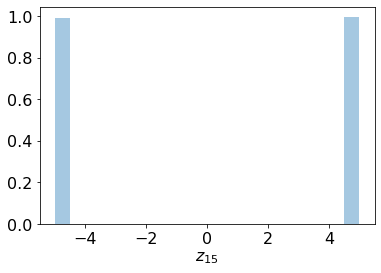

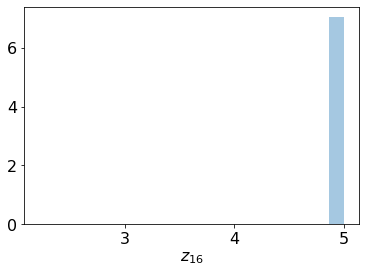

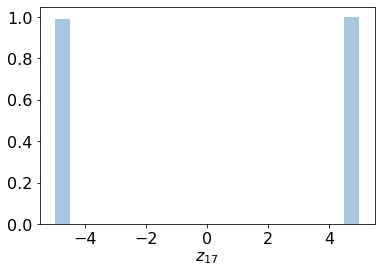

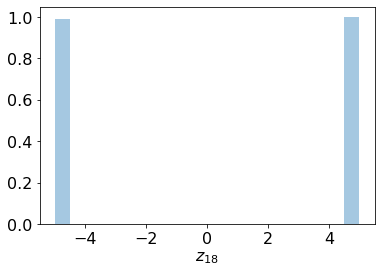

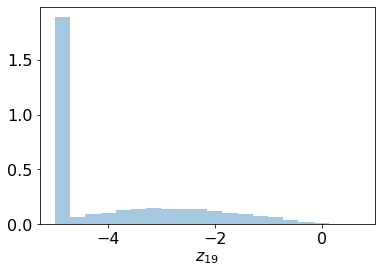

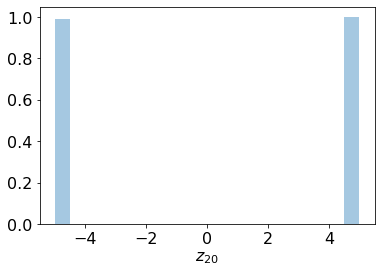

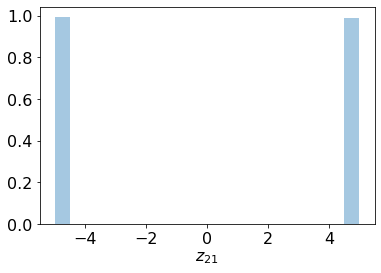

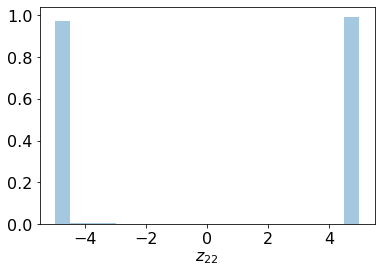

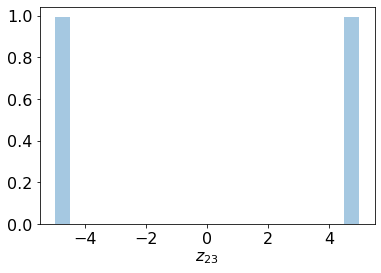

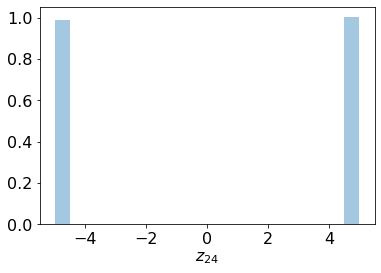

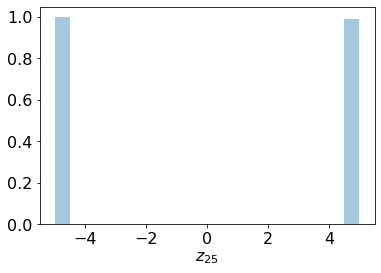

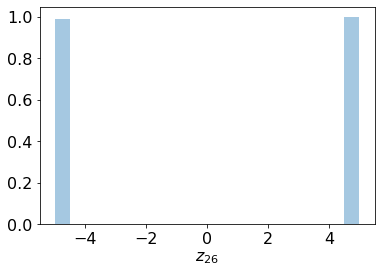

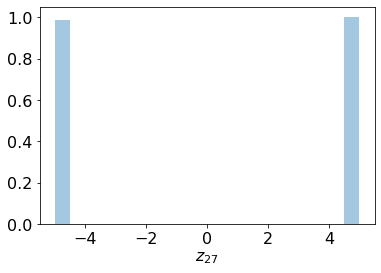

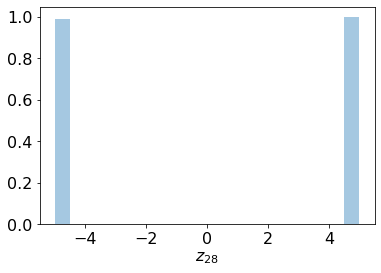

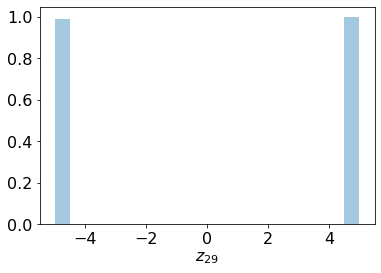

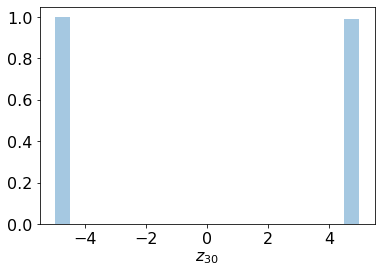

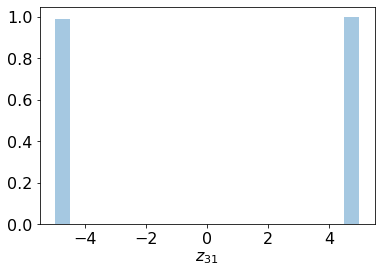

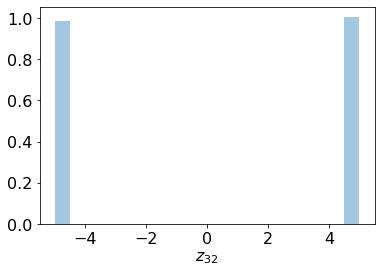

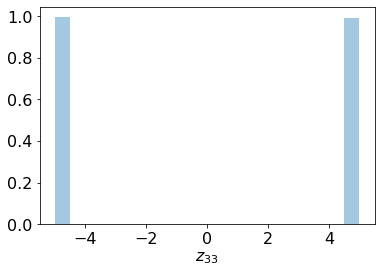

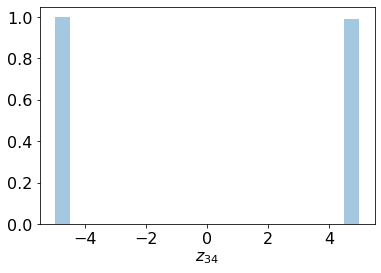

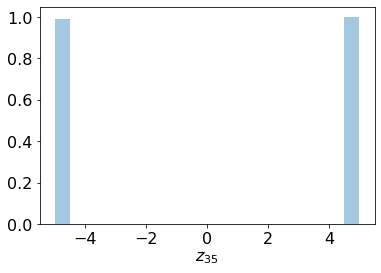

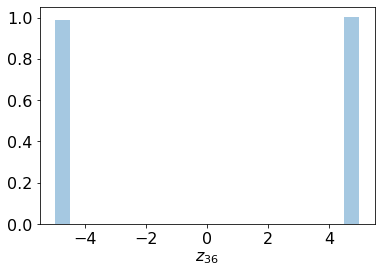

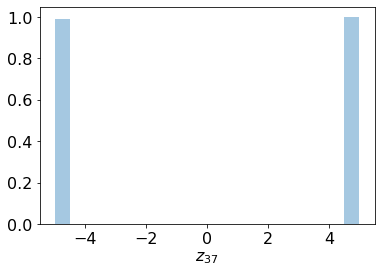

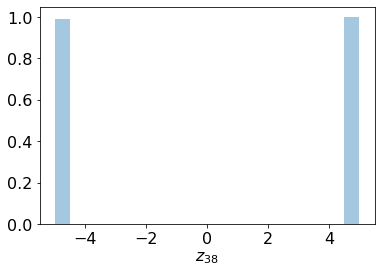

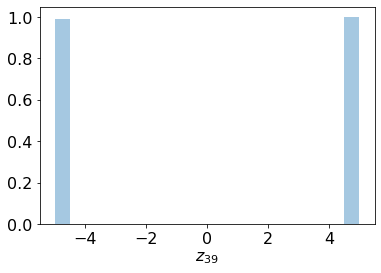

In [23]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

IndexError: list index out of range

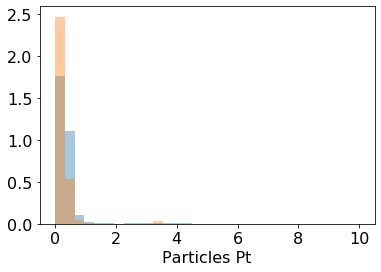

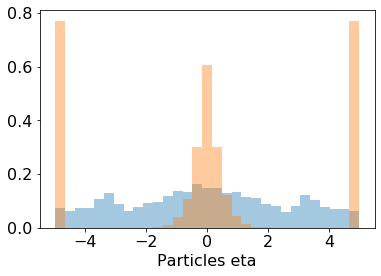

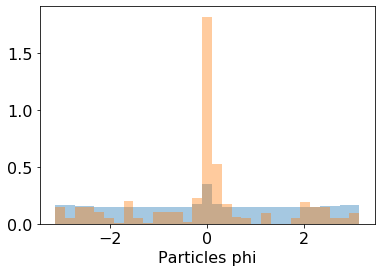

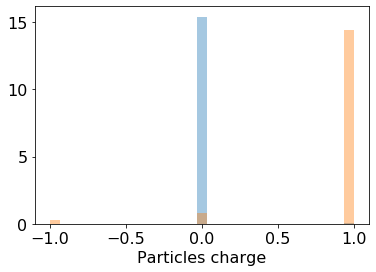

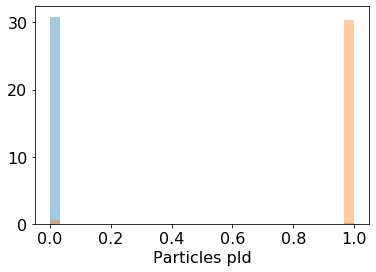

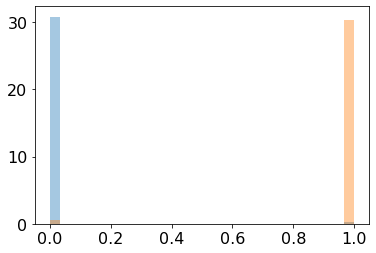

In [24]:
for i in range(x.shape[2]):
    x_aux = x[:,:,i].flatten()
    if i < 3:
        xp_aux = x_prime[:,:,i].flatten()
    elif i==3:
        xp_aux = np.argmax(x_prime[:,:,6:9], axis=2)
        xp_aux = xp_aux.flatten() - 1
    elif i==4:
        xp_aux = np.argmax(x_prime[:,:,9:14], axis=2).flatten()
        
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    if i == 0:
        r = (0,10)
    plt.hist(x_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=31, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset.feature_names[i])
#     plt.yscale('log')
    dnd.append(f)

# Performance evaluation

In [ ]:
dataset.loadValidationSamples('SM')

In [ ]:
model.eval()
for n in list(dataset.valSamples.keys()) + ['SMMix']:
    dataset.loss[n] = np.zeros((0))
    if n == 'SMMix':
        dataset.charge(dataset.SMMix_val)
    else:
        dataset.charge(dataset.valSamples[n])
    
    data_iter = torch.utils.data.DataLoader(dataset, **eval_params)
    pb = ProgressBar(len(data_iter), percentPrecision=5, headLabel=n+': ')
    for i, (local_x, _) in enumerate(data_iter):
        pb.show(i)
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
            
        x_prime = model(local_x)
        loss = criterion(local_x, x_prime, 'none').cpu().detach().numpy()
        dataset.loss[n] = np.concatenate((dataset.loss[n], loss))

In [ ]:
plt.figure(figsize=(12,8))
ra = np.array(list(map(lambda x: [np.min(x), np.quantile(x, 1-1e-3)], dataset.loss.values())))
r = (np.min(ra[:,0]), np.max(ra[:,1]))

for n in ['Ato4l','SMMix']:
    plt.hist(dataset.loss[n], bins=31, range=r,
             density=True,
             color=dataset.process_colors[n], 
             alpha=0.3, 
             label=dataset.process_labels[n])
plt.yscale('log')
plt.legend(loc='best')

In [ ]:
dic_ROC = createROC_curve(dataset)
pickle.dump(dic_ROC, open('data/dAE_v{}_ROC_dic.pkl'.format(AEversion), 'wb'))

In [ ]:
f_ROC, ax_arr = plt.subplots(2,2, figsize=(12,12))
for i, n in enumerate(dataset.BSM_names):
    f = open('../data/HLFref1811-10276_loss/VAE_all-in-one_v71_ROC1_dict_{}.pkl'.format(n), 'br')
    dRef = pickle.load(f, encoding='bytes')
    f.close()
    
    ax = ax_arr[int(i/2),i%2]
    ax.plot(dRef[b'eff_SM'], dRef[b'eff_BSM'], label=dataset.process_labels[n] + ' HLF',
            linestyle='--', lw=3, color=dataset.process_colors[n])
    ax.plot(dic_ROC[n]['eff_SM'], dic_ROC[n]['eff_BSM'], label=dataset.process_labels[n] + ' PF',
            linestyle='-', lw=3, color=dataset.process_colors[n])
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':')
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([1e-6, 1.05])
    ax.set_xlabel('SM efficiency')
    ax.set_ylabel('BSM efficiency')
    ax.set_title('')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
    ax.legend(loc='lower right')
    
f_ROC.tight_layout()

## Latent dimension clustering

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
dataset.encoded = {}

for n in dataset.BSM_names:    
    dataset.charge(dataset.valSamples[n][:10000])
    x_in = torch.Tensor(dataset.inputs)
    if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
    dataset.encoded[n] = model.encode(x_in).cpu().detach().numpy()
    
dataset.charge(dataset.SMMix_val[:10000])
x_in = torch.Tensor(dataset.inputs)
if model.onGPU:
        x_in = x_in.cuda(model.N_GPU)
dataset.encoded['SMMix'] = model.encode(x_in).cpu().detach().numpy()

In [ ]:
idx_max = 1000 #np.min(list(map(lambda x: x.shape[0], dataset.encoded.values())))
z_dset = np.zeros((0, model.Nk))

for n in dataset.encoded.keys():
    z_dset = np.concatenate((z_dset, dataset.encoded[n][:idx_max]))
    
z_embedded = TSNE(n_components=2).fit_transform(z_dset)

In [ ]:
f = plt.figure(figsize=(8,8))

for i, n in enumerate(dataset.encoded.keys()):
#     if not n in ['Ato4l', 'SMMix']: continue
    aux_z = z_embedded[i*idx_max: (i+1)*idx_max]
    plt.plot(aux_z[:,0], aux_z[:,1], 
             'o',
             color=dataset.process_colors[n], 
             mfc='none',
             label=dataset.process_labels[n])
    
plt.xlabel('Embedded 0')
plt.ylabel('Embedded 1')
plt.legend(loc='best')
f.tight_layout()